# Tagging a movie based on its plot synopsis

In this project, I intend to create a model which, when fed a synopsis of a movie's plot, will assign it tags, as done on [IMDb](https://www.imdb.com/).

For this purpose, I will be using a dataset of ~6000 movie summaries, with assigned tags to them. These tags are mutually exclusive, leading to a multi-label classification problem.

## 0. Importing necessary libraries and loading in dataset

In [345]:
import ast
import re
import string
import time
import importlib
import random
random.seed(42)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("omw-1.4")

early_stopping_pytorch = importlib.import_module("early-stopping-pytorch")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [346]:
!git clone https://github.com/Bjarten/early-stopping-pytorch

fatal: destination path 'early-stopping-pytorch' already exists and is not an empty directory.


In [347]:
raw_data = pd.read_csv("movie_plots.csv", sep=',', header=0, usecols=[2,3])
print(raw_data.isna().sum()) # Check for missing values
raw_data

tags    0
plot    0
dtype: int64


,tags,plot
0,['documentary'],A stationary camera looks across the boulevard...
1,"['pirates', 'scifi']",Undersea adventures in a submarine by a dreami...
2,['drama'],The Outwitting of an Andalusian Brigand by a P...
3,['drama'],Before the storm. Epoch-making days. Liberty s...
4,['drama'],John and Tom Wilkins are brothers and most div...
...,...,...
5590,"['politics', 'biopic']","November 22, 1963. President John F. Kennedy h..."
5591,['super_hero'],"Melvin, a reluctant Superhero, lives only for ..."
5592,['musical'],"One dark night, at water's edge, a family of m..."
5593,"['politics', 'comedy']","Three minutes in to her set, Amy Schumer claim..."


In [348]:
# Replacing tags:String to tags:List[String]
list_tags = []
for tag in raw_data["tags"]:
    tag = ast.literal_eval(tag)
    list_tags.append(tag)

raw_data["tags"] = list_tags
raw_data

,tags,plot
0,[documentary],A stationary camera looks across the boulevard...
1,"[pirates, scifi]",Undersea adventures in a submarine by a dreami...
2,[drama],The Outwitting of an Andalusian Brigand by a P...
3,[drama],Before the storm. Epoch-making days. Liberty s...
4,[drama],John and Tom Wilkins are brothers and most div...
...,...,...
5590,"[politics, biopic]","November 22, 1963. President John F. Kennedy h..."
5591,[super_hero],"Melvin, a reluctant Superhero, lives only for ..."
5592,[musical],"One dark night, at water's edge, a family of m..."
5593,"[politics, comedy]","Three minutes in to her set, Amy Schumer claim..."


## 1. Data Exploration

Before starting to train models, we should explore the dataset to see what insights we can obtain. Firstly, I'll look at the distribution of the tags assigned to each movie.

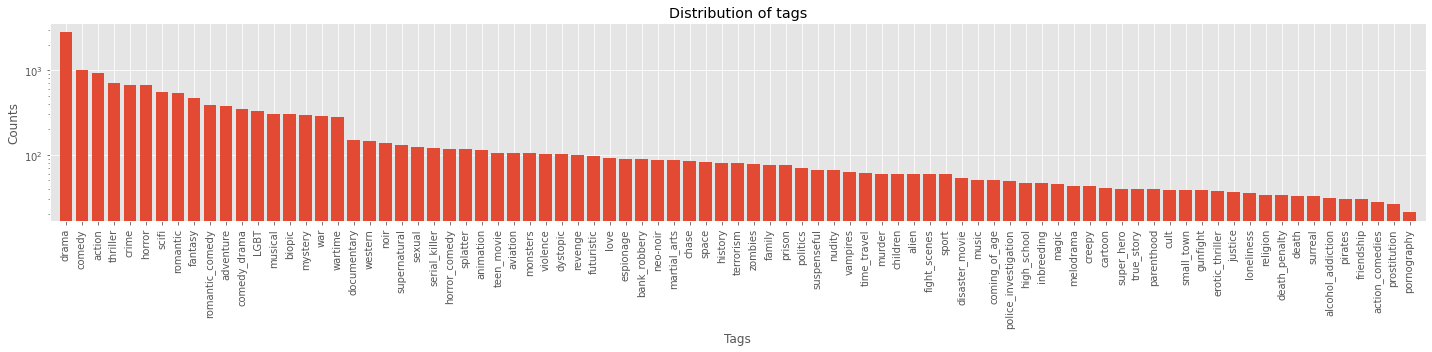

Number of tags: 85


In [349]:
def plot_tag_distribution(tags_col):
    tag_counts = pd.DataFrame({'tags': pd.Series([tag for tags in tags_col for tag in tags])}).apply(pd.value_counts) 
    # Plot tag distribution
    tag_names = tag_counts.index.values.tolist()
    total_tags = len(tag_names)
    tag_counts = tag_counts.values[:,0].tolist()

    fig = plt.figure(figsize=(20,5))
    plt.title('Distribution of tags')
    plt.xlabel('Tags')
    plt.ylabel('Counts')
    plt.xlim([-1, len(tag_names)])
    plt.bar(tag_names, tag_counts)
    plt.yscale('log')
    plt.xticks(rotation='vertical')
    plt.tight_layout()
    plt.show()
    return total_tags

total_tags = plot_tag_distribution(raw_data["tags"])
print(f"Number of tags: {total_tags}")

As we can see from the distribution of the tags, the dataset is quite unbalanced and shows a long tail. The difference between the most and least common tag is of almost 1.5 orders of magnitude. We should keep this in mind when training and evaluating our models, as simply predicting drama would artificially create a decent classifier.

Now let's have a look at the number of tags per movie.

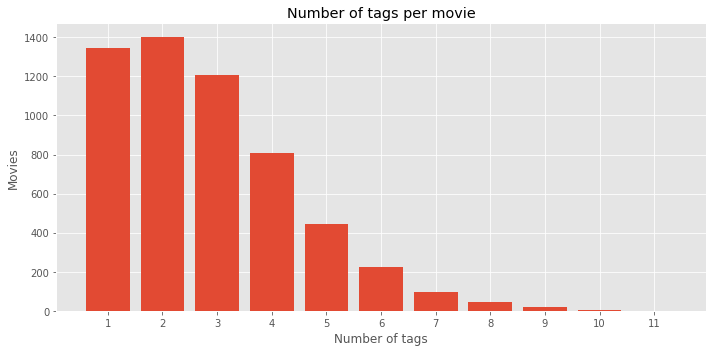

In [350]:
num_tags = raw_data["tags"].str.len()
counts, bins = np.histogram(num_tags, bins=max(num_tags)-1)

fig = plt.figure(figsize=(10,5))
plt.title('Number of tags per movie')
plt.xlabel('Number of tags')
plt.ylabel('Movies')
plt.xticks(bins)
plt.bar(bins[:-1], counts)
plt.tight_layout()
plt.show()

From this plot we can see that the dataset is indeed extremely unbalanced, not only in the distribution of tags, but also in the number of tags per movie. I'll keep this in mind when designing our models.

## 2. Data preparation

### 2.1 Label encoding

Now I have to prepare our data for training the models. Firstly, we have to encode the labels. Given that the dataset is multi-labeled, we can't just apply a simple encoding mechanism, such as 1-hot, as each feature might have more than one target. For this end, I'll encode with a [MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html). We will also define our features as $X$ (plot synopsis) and our labels as $y$ (tags). 

In [351]:
X = raw_data["plot"]
y = raw_data["tags"]

In [352]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
print(y.shape)

(5595, 85)


In [353]:
# Cross check with raw data to confirm it's working (and that there's a lot of drama)
print(y[0:3])
print(mlb.inverse_transform(y[0:3]))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0]]
[('documentary',), ('pirates', 'scifi'), ('drama',)]


### 2.2 Preparing the features

In order to train and evaluate the models, I have to first split the dataset into a train, a validation and a test dataset. Given that the dataset is unbalanced, one has to make sure to preserve the distribution of tags in all sets, and make sure that all sets contain all tags. For this reason I stratify the sampling of the dataset. However, the dataset is multi-labelled, and so traditional single-label stratification methods will not work, as described [here](http://scikit.ml/stratification.html). I will use sk-multilearn's implementation of iterative stratification. 

In [354]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [355]:
from skmultilearn.model_selection.iterative_stratification import IterativeStratification

def iterative_train_test_split(X, y, test_size):
    stratifier = IterativeStratification(
        n_splits=2, order=1, sample_distribution_per_fold=[test_size, 1-test_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

# Can't split into 3 sets for some reason!!

# def train_val_test_split(X, y, test_size=0.1, val_size=0.2):
#     X_trainval, X_test, y_trainval, y_test = iterative_train_test_split(X, y, test_size=test_size)
#     # print(X_trainval.shape, y_trainval.shape)
#     # print(X_test.shape, y_test.shape)
#     X_train, X_val, y_train, y_val = iterative_train_test_split(X_trainval, y_trainval, test_size=val_size)#/(1-test_size))
#     return X_train, X_val, X_test, y_train, y_val, y_test

# def iterative_train_val_test_split(X, y, val_size, test_size):
#     stratifier = IterativeStratification(
#         n_splits=3, order=1, sample_distribution_per_fold=[1-test_size-val_size, val_size, test_size])
#     train_indices, val_indices, test_indices = next(stratifier.split(X, y)) #<-- Returns only 2 sets of indices, not 3
#     X_train, y_train = X[train_indices], y[train_indices]
#     X_test, y_test = X[test_indices], y[test_indices]
#     return X_train, X_test, y_train, y_test

In [356]:
X_train_complete, X_val_complete, y_train, y_val = iterative_train_test_split(X, y, 0.1)
print(X_train_complete.shape, y_train.shape)
print(X_val_complete.shape, y_val.shape)

(4872,) (4872, 85)
(723,) (723, 85)


Having stratified the data when creating the train-val split, we expect a similar distribution of tags in the train and val set as that of the entire dataset.

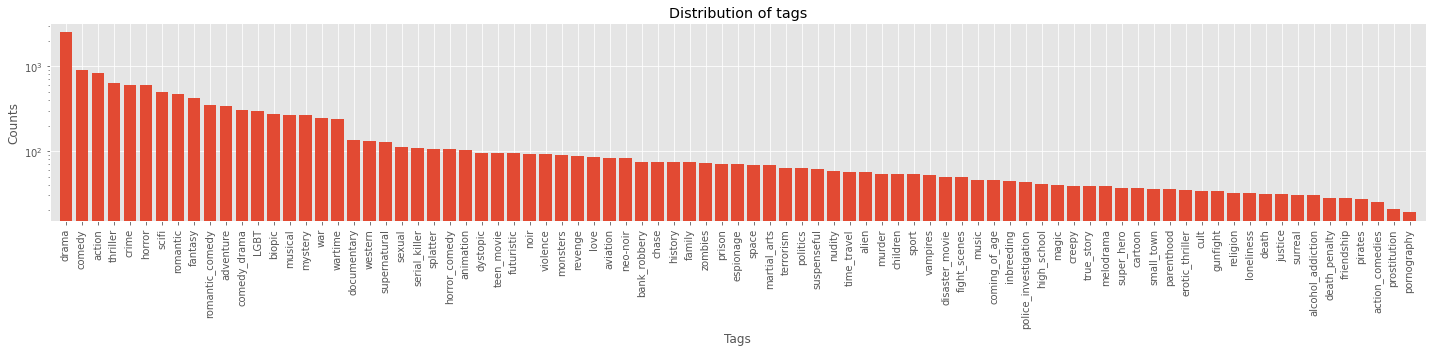

Number of tags: 85


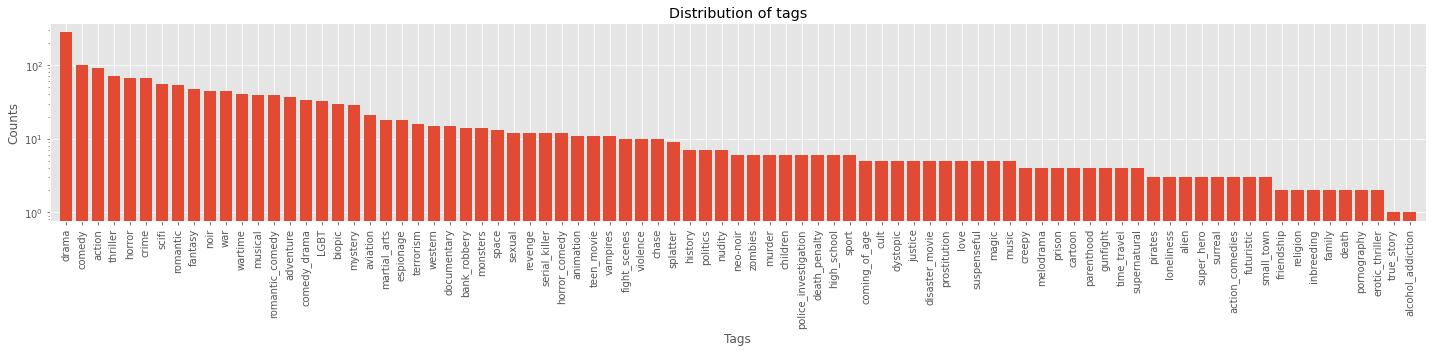

Number of tags: 85


In [357]:
train_tags = plot_tag_distribution(mlb.inverse_transform(y_train_complete))
print(f"Number of tags: {train_tags}")
val_tags = plot_tag_distribution(mlb.inverse_transform(y_val_complete))
print(f"Number of tags: {val_tags}")

Given that the features contain text, it is necessary to pre-process this text. Firstly, I will make the text more uniform by casting everything to lowercase, cleaning extra whitespace, removing punctuation and removing any rogue HTML tags. Furthermore, I will strip the sentences of unnecessary stop words. This way, only the important words are used by the model to train. Furthermore, unimportant word endings will also be removed. Two methods will be tested; [stemming](https://en.wikipedia.org/wiki/Stemming) and [lemmatization](https://en.wikipedia.org/wiki/Lemmatisation).



In [358]:
stopwords = stopwords.words("english")
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

In [359]:
def get_wordnet_pos(tag):
    """ Map NLTK position tags """
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(texts, method=None):
    """ :method: - ['stemming', 'lemmatization'] """
    clean_texts = []
    for text in texts:
        clean_text = []
        text = text.lower()
        text = text.strip()
        text = re.sub("[^\w\s\d]", " ", text)
        text = re.sub("\s+", " ", text)
        text = re.sub("<.*?>", "", text)
        if method == 'stemming':
            for word in word_tokenize(text):
                if word not in stopwords:
                    clean_text.append(stemmer.stem(word))
        elif method == 'lemmatization':
            lemmatized_text = []
            words = word_tokenize(text)
            word_pos_tags = nltk.pos_tag(words)
            for idx, tag in enumerate(word_pos_tags):
                lemmatized_text.append(lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])))
            for word in lemmatized_text:
                if word not in stopwords:
                    clean_text.append(word)
        else:
            raise ValueError("Choose either 'stemming' or 'lemmatization' as the method")
        clean_texts.append(" ".join(clean_text))
    return clean_texts

In [360]:
# Lets test it out
movie_plot = X_train_complete.iloc[0]
print(f"Raw text: \n{movie_plot}\n")
print(f"Preprocessed text with stemming:\n{clean_text([movie_plot], method='stemming')}\n")
print(f"Preprocessed text with lemmatization:\n{clean_text([movie_plot], method='lemmatization')}")

Raw text: 
A stationary camera looks across the boulevard at a diagonal toward one corner of Lyon's Cordeliers' Square. It's a long shot, with a great deal of depth of focus. We can see the sky and fronts of four buildings, each four or five stories tall. It's a busy thoroughfare, with pedestrians walking in front of the buildings and crossing the boulevard between horse-drawn vehicles. A double-decker bus passes in front of us, pulled by two horses. Various tradesmen pass on wagons. One van passes.

Preprocessed text with stemming:
['stationari camera look across boulevard diagon toward one corner lyon cordeli squar long shot great deal depth focus see sky front four build four five stori tall busi thoroughfar pedestrian walk front build cross boulevard hors drawn vehicl doubl decker bus pass front us pull two hors various tradesmen pass wagon one van pass']

Preprocessed text with lemmatization:
['stationary camera look across boulevard diagonal toward one corner lyon cordeliers squa

# 

# 3. Fitting a simple model

Now we move on to fitting the first model. First, I will clean the texts using stemming.

In [361]:
X_train = clean_text(X_train_complete, 'stemming')
X_val = clean_text(X_val_complete, 'stemming')

The feature texts need to be encoded. I will extract their TF-IDF vectors.

In [362]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_features = 750
tfidf_vectorizer = TfidfVectorizer(max_features=tfidf_features)

tfidf_vectorizer.fit(X_train)

X_train = tfidf_vectorizer.transform(X_train).toarray()
X_val = tfidf_vectorizer.transform(X_val).toarray()

## 3.1 Defining the model

The first model I will fit is a very simple logistic regression, a.k.a. a single layered neural network.

In [363]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Here I define the hyperparameters that will be optimized. I will be leaving the learning rate mostly fixed, as altering the batch size leads to an equivalent result, as discussed [in this paper](https://arxiv.org/abs/1711.00489).

In [364]:
# Model hyperparameters
batch_size = 8
num_epochs = 150
learning_rate = 1e-2

In [412]:
class SingleLayerNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.net_stack = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=output_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        logits = self.net_stack(x)
        return logits
    
model = SingleLayerNetwork(tfidf_features, total_tags).to(device)
print(model)

SingleLayerNetwork(
  (net_stack): Sequential(
    (0): Linear(in_features=750, out_features=85, bias=True)
    (1): Sigmoid()
  )
)


To train this model I will use a binary cross entropy loss function and an Adam optimizer. The model parameters will be initialized with the [default](https://pytorch.org/tutorials/prototype/skip_param_init.html) Linear parameter initialization. I'll also prepare the data to be fed to the model.

In [413]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 3.2 Training the model

In [414]:
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32),
)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [409]:
def train_model(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        # Compute loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= num_batches
    return train_loss
    # return loss.item() / size

In [410]:
def val_model(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            # Compute loss
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
    val_loss /= num_batches
    return val_loss

In [370]:
def plot_accuracy_per_epoch(accuracy_list, train_loss_list, val_loss_list):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize = (6,8), sharex=True)
    axs[0].plot(range(len(accuracy_list)), accuracy_list)
    axs[1].plot(range(len(val_loss_list)), val_loss_list, label='Test loss')
    axs[1].plot(range(len(train_loss_list)), train_loss_list, label='Train loss')
    plt.subplots_adjust(hspace=0)
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    axs[0].set_ylabel("Accuracy")

def plot_loss_per_epoch(train_loss_list, val_loss_list):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (6,4), sharex=True)
    axs.plot(range(len(val_loss_list)), val_loss_list, label='Val loss')
    axs.plot(range(len(train_loss_list)), train_loss_list, label='Train loss')
    axs.set_xlabel("Epoch")
    axs.set_ylabel("Loss")
    axs.legend()


In order not to overtrain my models, I will implement early stopping in my training loop. I'll use the [early-stopping-pytorch](https://github.com/Bjarten/early-stopping-pytorch) module.

In [380]:
def train_and_val(train_loader, val_loader):
    train_loss_list, val_loss_list = [], []
    total_time = 0
    early_stopping = early_stopping_pytorch.pytorchtools.EarlyStopping(patience=10, verbose=False)
    for t in range(num_epochs):
        t_start = time.time()
        train_loss = train_model(train_loader, model, loss_fn, optimizer)
        val_loss = val_model(val_loader, model, loss_fn)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        epoch_time = time.time()-t_start
        total_time += epoch_time
        print(f"Epoch {t+1:>3} --- Validation loss {val_loss:.5f} --- {epoch_time:.3f}s")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    print(f"Total training time: {total_time:.3f}s")
    return train_loss_list, val_loss_list

Epoch  1 --- Validation loss 9.22670 --- 0.676s
Epoch  2 --- Validation loss 9.15008 --- 0.699s
Epoch  3 --- Validation loss 9.09982 --- 0.695s
Epoch  4 --- Validation loss 9.07121 --- 0.706s
Epoch  5 --- Validation loss 9.05625 --- 0.724s
Epoch  6 --- Validation loss 9.04972 --- 0.682s
Epoch  7 --- Validation loss 9.04776 --- 0.688s
Epoch  8 --- Validation loss 9.04762 --- 0.686s
Epoch  9 --- Validation loss 9.04785 --- 0.684s
EarlyStopping counter: 1 out of 10
Epoch 10 --- Validation loss 9.05035 --- 0.690s
EarlyStopping counter: 2 out of 10
Epoch 11 --- Validation loss 9.05400 --- 0.691s
EarlyStopping counter: 3 out of 10
Epoch 12 --- Validation loss 9.05808 --- 0.689s
EarlyStopping counter: 4 out of 10
Epoch 13 --- Validation loss 9.06224 --- 0.690s
EarlyStopping counter: 5 out of 10
Epoch 14 --- Validation loss 9.06624 --- 0.677s
EarlyStopping counter: 6 out of 10
Epoch 15 --- Validation loss 9.07002 --- 0.713s
EarlyStopping counter: 7 out of 10
Epoch 16 --- Validation loss 9.0736

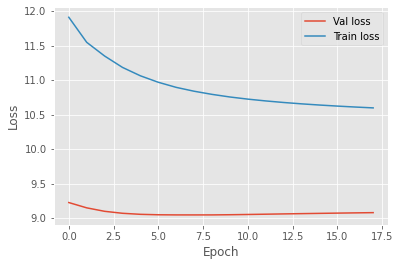

In [415]:
train_loss_list, val_loss_list = train_and_val(train_loader, val_loader)
plot_loss_per_epoch(train_loss_list, val_loss_list)

## 3.3 Evaluating the model

Now we have to evaluate the model. This can be tricky because of the dataset's nature. Firstly, since the dataset is extremely unbalanced, just predicting the most common tag every time (drama) would yield a decent accuracy. We obviously want to train a better model than this, and as such have to use different metrics. Firstly, I will use the F1-score. Since the data is unbalanced, the macro F1 score has to be used, as the micro F1 score would not count for the long tail of the tag distribution. To compare models I will also use the ROC curve and AUC. Secondly, since the dataset is multi-labelled, we have to take the mean of the results of these scores for all tags.

In [416]:
from sklearn.metrics import f1_score

with torch.no_grad():
    pred = model(torch.tensor(X_val, dtype=torch.float32).to(device))

y_pred = np.rint(pred.detach().cpu().numpy())
y_true = y_val#.detach().cpu().numpy()


f1score = f1_score(y_true, y_pred, average='weighted') # average='weighted' yields macro f1 score, taking weighted average of all labels
f1score

0.2763226505281892

128 -> 0.27031307607737237

1024 -> 0.2696908553214005

32 -> 0.2736664856760335 (1e-2)

16 -> 0.2747710095079293

8 -> 0.2754668394040625



## 3.4 Training same model on lemmatized data

Now we will test which of the two cleaning methods is better

In [417]:
X_train = clean_text(X_train_complete, 'lemmatization')
X_val = clean_text(X_val_complete, 'lemmatization')

In [418]:
tfidf_vectorizer = TfidfVectorizer(max_features=tfidf_features)

tfidf_vectorizer.fit(X_train)

X_train = tfidf_vectorizer.transform(X_train).toarray()
X_val = tfidf_vectorizer.transform(X_val).toarray()

In [419]:
# Model hyperparameters
batch_size = 8
num_epochs = 150
learning_rate = 1e-2

In [420]:
# Same model, loss and optimizer as before
model = SingleLayerNetwork(tfidf_features, total_tags).to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32),
)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

SingleLayerNetwork(
  (net_stack): Sequential(
    (0): Linear(in_features=750, out_features=85, bias=True)
    (1): Sigmoid()
  )
)


Epoch  1 --- Validation loss 9.22653 --- 0.692s
Epoch  2 --- Validation loss 9.14983 --- 0.688s
Epoch  3 --- Validation loss 9.09974 --- 0.692s
Epoch  4 --- Validation loss 9.07131 --- 0.733s
Epoch  5 --- Validation loss 9.05639 --- 0.700s
Epoch  6 --- Validation loss 9.04980 --- 0.702s
Epoch  7 --- Validation loss 9.04776 --- 0.730s
Epoch  8 --- Validation loss 9.04773 --- 0.704s
Epoch  9 --- Validation loss 9.04791 --- 0.704s
EarlyStopping counter: 1 out of 10
Epoch 10 --- Validation loss 9.05042 --- 0.718s
EarlyStopping counter: 2 out of 10
Epoch 11 --- Validation loss 9.05409 --- 0.703s
EarlyStopping counter: 3 out of 10
Epoch 12 --- Validation loss 9.05809 --- 0.774s
EarlyStopping counter: 4 out of 10
Epoch 13 --- Validation loss 9.06210 --- 0.797s
EarlyStopping counter: 5 out of 10
Epoch 14 --- Validation loss 9.06600 --- 0.856s
EarlyStopping counter: 6 out of 10
Epoch 15 --- Validation loss 9.06979 --- 0.710s
EarlyStopping counter: 7 out of 10
Epoch 16 --- Validation loss 9.0734

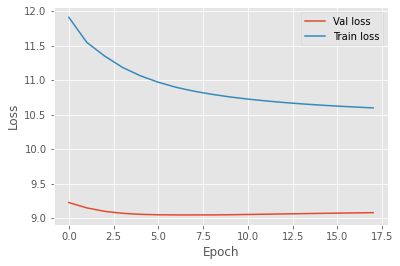

In [421]:
train_loss_list, val_loss_list = train_and_val(train_loader, val_loader)
plot_loss_per_epoch(train_loss_list, val_loss_list)

In [422]:
with torch.no_grad():
    pred = model(torch.tensor(X_val, dtype=torch.float32).to(device))

y_pred = np.rint(pred.detach().cpu().numpy())
y_true = y_val#.detach().cpu().numpy()


f1score = f1_score(y_true, y_pred, average='weighted') # average='weighted' yields macro f1 score, taking weighted average of all labels
f1score

0.2761468100151409